## Part 4 Linear Model Pipeline & Optimization  

### 1. Load the Processed Data for Modeling

We load the fully engineered feature sets produced before:
- `X_train`: Includes all numerical, categorical, and advanced features (e.g., KNN-based)
- `X_test`: Same structure as training features, used for final evaluation

We also load `y_train` and `y_test` from the original raw data files, which contain the actual sale prices used as ground truth targets.

Note: The `price` column was included in the training feature set during earlier stages (e.g., for constructing KNN-based features). We now remove it from `X_train` to avoid target leakage, as this column serves as the prediction target.

In [ ]:
import pandas as pd
import numpy as np

# Load required data
# drop the 'price' column as it was only there for use in generating knn features before
X_train = pd.read_csv("engineered_categorical_train_knn.csv").drop(columns=["price"])  
y_train = pd.read_csv("train_data.csv")["log10_price"]

# Load test features and true price
X_test = pd.read_csv("engineered_categorical_test_knn.csv")
y_test = pd.read_csv("test_data.csv")["price"]  # actual price for evaluation

### 2. Build the full linear model pipeline, including feature scaling if necessary.

#### a. Baseline Model: Ordinary Least Squares (OLS)

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Create a pipeline with scaling and OLS
ols_pipeline = Pipeline([
    ("scaler", StandardScaler()),        # Standardize features
    ("ols", LinearRegression())          # Ordinary Least Squares model
])

# Cross-validation (on training set)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
def evaluate_cv_mape(model, X, y, cv):
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)
    return -scores.mean() * 100
cv_mape_ols = evaluate_cv_mape(ols_pipeline, X_train, y_train, cv)
print(f"Cross-Validation MAPE: {cv_mape_ols:.2f}%")

Cross-Validation MAPE: 1.57%


We then predict `log(price)` instead of `price` because house prices are highly skewed, and the log transformation makes the data more normally distributed and stable. \
This helps the linear model perform better and aligns with our evaluation metric (MAPE), which is based on percentage error. \
Predicting `log(price)` also makes the model more interpretable and less sensitive to outliers.

In [9]:
# Fit the model
ols_pipeline.fit(X_train, y_train)

# Predict log(price)
y_pred_log_test = ols_pipeline.predict(X_test)

After predicting, we convert the result back to actual price because:

- The evaluation metric (MAPE) is based on the actual price, not its log.

- Real-world interpretation and decision-making are done using real prices.

In [10]:
from sklearn.metrics import mean_absolute_percentage_error

# Convert log(price) back to real price
y_pred_test = 10 ** y_pred_log_test

# Evaluate using MAPE
mape_ols = mean_absolute_percentage_error(y_test, y_pred_test)
print(f"OLS Test MAPE: {mape_ols * 100:.2f}%")


OLS Test MAPE: 25.82%


The OLS model achieved a test MAPE of 25.82%, indicating that predictions were off by approximately 25.82% on average relative to actual house prices.


#### b. Ridge Regression Model

In [ ]:
from sklearn.linear_model import RidgeCV

# Define RidgeCV pipeline
ridge_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Feature scaling
    ("ridge", RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5))  # RidgeCV includes internal cross-validation
])

# Evaluate cross-validation MAPE
# (using the same evaluate_cv_mape function)
cv_mape_ridge = evaluate_cv_mape(ridge_pipeline, X_train, y_train, cv)
print(f"Ridge CV MAPE: {cv_mape_ridge:.2f}%")

Ridge CV MAPE: 1.57%


In [12]:
# Fit Ridge model and evaluate on test set
ridge_pipeline.fit(X_train, y_train)

# Predict and convert back to original price
y_pred_log_ridge = ridge_pipeline.predict(X_test)
y_pred_ridge = 10 ** y_pred_log_ridge

# Compute Test MAPE
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge) * 100
print(f"Ridge Test MAPE: {mape_ridge:.2f}%")

Ridge Test MAPE: 25.81%


#### c. Lasso Regression Model

In [14]:
from sklearn.linear_model import LassoCV

# Define LassoCV pipeline
lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(alphas=[0.001, 0.01, 0.1, 1.0], cv=5, random_state=42, max_iter=10000))
])

# Evaluate cross-validation MAPE
cv_mape_lasso = evaluate_cv_mape(lasso_pipeline, X_train, y_train, cv)
print(f"Lasso CV MAPE: {cv_mape_lasso:.2f}%")

Lasso CV MAPE: 1.58%


In [15]:
# Fit Lasso and evaluate on test set
lasso_pipeline.fit(X_train, y_train)

y_pred_log_lasso = lasso_pipeline.predict(X_test)
y_pred_lasso = 10 ** y_pred_log_lasso

mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso) * 100
print(f"Lasso Test MAPE: {mape_lasso:.2f}%")

Lasso Test MAPE: 25.83%


In [18]:
results = pd.DataFrame({
    "Model": ["OLS", "Ridge", "Lasso"],
    "CV MAPE (%)": [cv_mape_ols, cv_mape_ridge, cv_mape_lasso],
    "Test MAPE (%)": [mape_ols * 100, mape_ridge, mape_lasso]
})

print(results)

   Model  CV MAPE (%)  Test MAPE (%)
0    OLS     1.573558      25.822100
1  Ridge     1.573940      25.814383
2  Lasso     1.582534      25.834244


#### d. ElasticNet Model

In addition to Ridge and Lasso, we also evaluated ElasticNet, which combines L1 and L2 regularization. 

In [20]:
from sklearn.linear_model import ElasticNetCV

# Define ElasticNet pipeline
elastic_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("elasticnet", ElasticNetCV(
        l1_ratio=[0.1, 0.5, 0.9],         # Mix between L1 and L2
        alphas=[0.001, 0.01, 0.1, 1.0],   # Regularization strengths
        cv=5,
        max_iter=10000,
        random_state=42
    ))
])

# Cross-validation MAPE
# ---------------------------------------
cv_mape_elastic = evaluate_cv_mape(elastic_pipeline, X_train, y_train, cv)
print(f"ElasticNet CV MAPE: {cv_mape_elastic:.2f}%")

ElasticNet CV MAPE: 1.57%


In [21]:
# Fit and evaluate on test set
elastic_pipeline.fit(X_train, y_train)

y_pred_log_elastic = elastic_pipeline.predict(X_test)
y_pred_elastic = 10 ** y_pred_log_elastic

mape_elastic = mean_absolute_percentage_error(y_test, y_pred_elastic) * 100
print(f"ElasticNet Test MAPE: {mape_elastic:.2f}%")

ElasticNet Test MAPE: 25.76%


In [22]:
results.loc[len(results)] = ["ElasticNet", cv_mape_elastic, mape_elastic]
print(results)

        Model  CV MAPE (%)  Test MAPE (%)
0         OLS     1.573558      25.822100
1       Ridge     1.573940      25.814383
2       Lasso     1.582534      25.834244
3  ElasticNet     1.573714      25.757694


In [26]:
best_alpha = elastic_pipeline.named_steps["elasticnet"].alpha_
best_l1_ratio = elastic_pipeline.named_steps["elasticnet"].l1_ratio_

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")


Best alpha: 0.001
Best l1_ratio: 0.1


In [23]:
# Final evaluation using ElasticNet on held-out test set
y_pred_log_final = elastic_pipeline.predict(X_test)
y_pred_final = 10 ** y_pred_log_final

final_test_mape = mean_absolute_percentage_error(y_test, y_pred_final) * 100
print(f"✅ Final ElasticNet Test MAPE: {final_test_mape:.2f}%")


✅ Final ElasticNet Test MAPE: 25.76%


### 3. Model Diagnostics

#### Coefficient Interpretation (Feature Importance)
To understand the influence of each variable, we extracted the coefficients from the final ElasticNet model. 



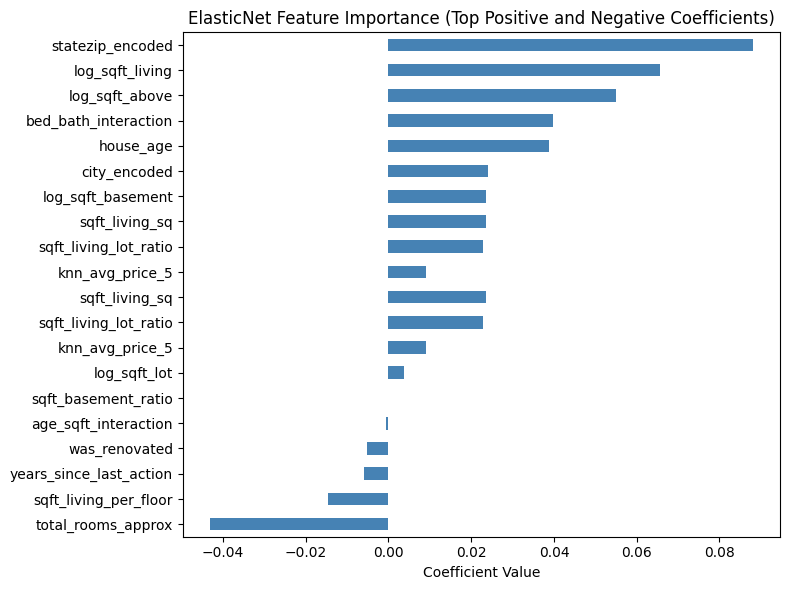

In [24]:
coefs = elastic_pipeline.named_steps["elasticnet"].coef_
feature_importance = pd.Series(coefs, index=X_train.columns).sort_values()

# Top positive/negative coefficients
top_pos = feature_importance.tail(10)
top_neg = feature_importance.head(10)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
pd.concat([top_neg, top_pos]).plot(kind='barh', color='steelblue')
plt.title("ElasticNet Feature Importance (Top Positive and Negative Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()


As shown in the plot, the most influential positive predictors include:

- `statezip_encoded`: Location-based target encoding of postal code had the largest positive impact, confirming that neighborhood significantly drives house value.
- `log_sqft_living`: Log-transformed total living area strongly correlates with price, as expected.
- `log_sqft_above` and `bed_bath_interaction`: These features represent internal space and layout, and had moderate positive influence.

On the other hand, several features had a negative impact on price:

- `total_rooms_approx` and `sqft_living_per_floor`: Larger values in these features may indicate inefficient layouts or excessive unused space.
- `years_since_last_action`: Older properties without recent transactions or renovations were associated with lower prices.

The use of ElasticNet allowed the model to automatically shrink unimportant features while retaining those with consistent predictive power. This validates the effectiveness of our feature engineering and reinforces domain expectations (e.g., space, condition, and location matter most).

#### Residual Analysis

We then examined residuals to assess whether the model captured the data distribution well. 

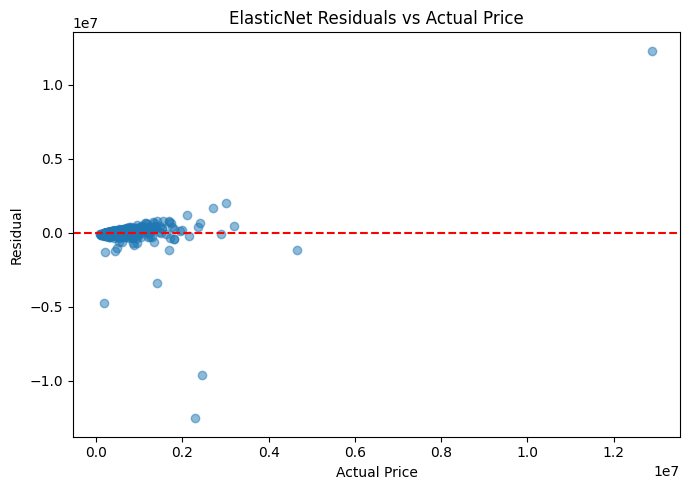

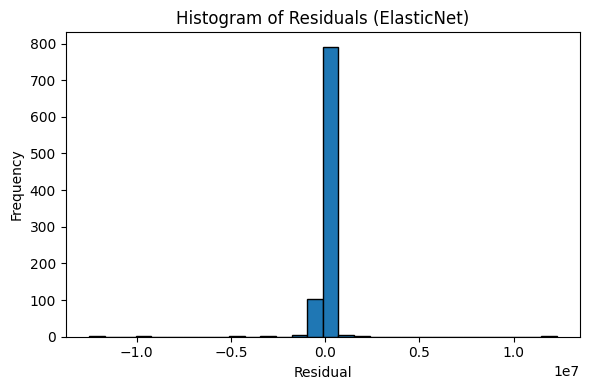

In [25]:
# Calculate residuals
residuals = y_test - y_pred_elastic

# Residuals vs Actual Values (Scatter Plot)
plt.figure(figsize=(7, 5))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Price")
plt.ylabel("Residual")
plt.title("ElasticNet Residuals vs Actual Price")
plt.tight_layout()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title("Histogram of Residuals (ElasticNet)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


**1. Residuals vs Actual Price**  
The scatter plot shows residuals plotted against actual house prices. Most predictions cluster tightly around zero, indicating strong model calibration for mid-range prices. However, the model tends to underpredict extremely high-priced houses — a limitation of linear models when capturing nonlinear price escalation in luxury segments.

**2. Histogram of Residuals**  
The histogram shows that the majority of residuals are symmetrically distributed around zero, suggesting the model is not heavily biased in either direction. A few outliers do exist, but they are rare and expected given the natural variability in housing markets.

Together, these diagnostics confirm that the model captures key pricing patterns while acknowledging some challenges in modeling extreme values.

### 4. KNN Ablation Test (with vs without `knn_avg_price_5`)

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

# === Pipeline WITH KNN feature ===
elastic_pipeline_knn = Pipeline([
    ("scaler", StandardScaler()),
    ("elasticnet", ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1.0], l1_ratio=[0.2, 0.5, 0.8], cv=5, random_state=42))
])
elastic_pipeline_knn.fit(X_train, y_train)
y_pred_log_knn = elastic_pipeline_knn.predict(X_test)
y_pred_knn = 10 ** y_pred_log_knn
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn) * 100
print(f"ElasticNet with KNN MAPE: {mape_knn:.2f}%")

# === Pipeline WITHOUT KNN feature ===
X_train_noknn = X_train.drop(columns=['knn_avg_price_5'], errors='ignore')
X_test_noknn = X_test.drop(columns=['knn_avg_price_5'], errors='ignore')

elastic_pipeline_noknn = Pipeline([
    ("scaler", StandardScaler()),
    ("elasticnet", ElasticNetCV(alphas=[0.001, 0.01, 0.1, 1.0], l1_ratio=[0.2, 0.5, 0.8], cv=5, random_state=42))
])
elastic_pipeline_noknn.fit(X_train_noknn, y_train)
y_pred_log_noknn = elastic_pipeline_noknn.predict(X_test_noknn)
y_pred_noknn = 10 ** y_pred_log_noknn
mape_noknn = mean_absolute_percentage_error(y_test, y_pred_noknn) * 100
print(f"ElasticNet WITHOUT KNN MAPE: {mape_noknn:.2f}%")


ElasticNet with KNN MAPE: 25.75%
ElasticNet WITHOUT KNN MAPE: 25.78%
